# Защита персональных данных клиентов

Необходимо защитить данные клиентов страховой компании «Хоть потоп». 

Задача проекта: разработать метод преобразования данных и обосновать корректность его работы. 

Цель проекта: сохранить качество моделей машинного обучения без ухудшений.

<b>План проекта:</b>

1. Загрузить и изучить данные.
2. Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии?
3. Предложить алгоритм преобразования данных для решения задачи.
4. Запрограммировать предложенный алгоритм, применив матричные операции. Применить метрику R2.

<b>Описание данных:</b>
- Признаки: пол, возраст и зарплата застрахованного, количество членов его семьи.
- Целевой признак: количество страховых выплат клиенту за последние 5 лет.

## Загрузка данных

In [1]:
#загрузим необходимые библиотеки
import os

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Загрузим датасет

def read_df(df):
    if os.path.exists('/datasets/'+df):
        df_raw = pd.read_csv('/datasets/'+df)
        print('platform')
    else:
        df_raw = pd.read_csv(df)
        print('remote')
    return df_raw
    
df_raw = read_df('insurance.csv')

platform


In [3]:
#посмотрим на порядок данных 
df_raw.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [4]:
#проверим пропуски
df_raw.isna().mean()

Пол                  0.0
Возраст              0.0
Зарплата             0.0
Члены семьи          0.0
Страховые выплаты    0.0
dtype: float64

In [5]:
#посмотрим на распределение целевого признака
df_raw.groupby('Страховые выплаты').agg(['count', 'mean'])

Пол           Возраст            Зарплата                \
                  count      mean   count       mean    count          mean   
Страховые выплаты                                                             
0                  4436  0.499324    4436  28.970694     4436  39924.752029   
1                   423  0.468085     423  44.706856      423  40260.520095   
2                   115  0.600000     115  50.860870      115  39035.652174   
3                    18  0.444444      18  55.833333       18  37677.777778   
4                     7  0.571429       7  60.000000        7  34057.142857   
5                     1  1.000000       1  65.000000        1  39700.000000   

                  Члены семьи            
                        count      mean  
Страховые выплаты                        
0                        4436  1.205816  
1                         423  1.139480  
2                         115  1.017391  
3                          18  0.944444  
4                           7  0.714286  
5                           1  1.000000

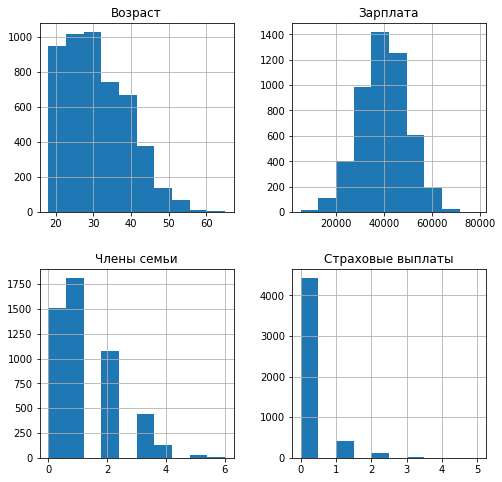

In [6]:
#также посмотрим на частоту значений в числовых столбцах
t = df_raw.drop('Пол', axis=1)
t.hist(figsize=(8,8));

Исходные данные содержат численные значения. В столбце 'Пол' содержатся категории. В столбцах 'Члены семьи' и 'Страховые выплаты' - целочисленные значений, в остальных двух столбцах представлены вещественные значения. В целом данные распределены нормально, выброы незначительны, а пропусков нет. Исходные данные не нуждаются в предобработке.

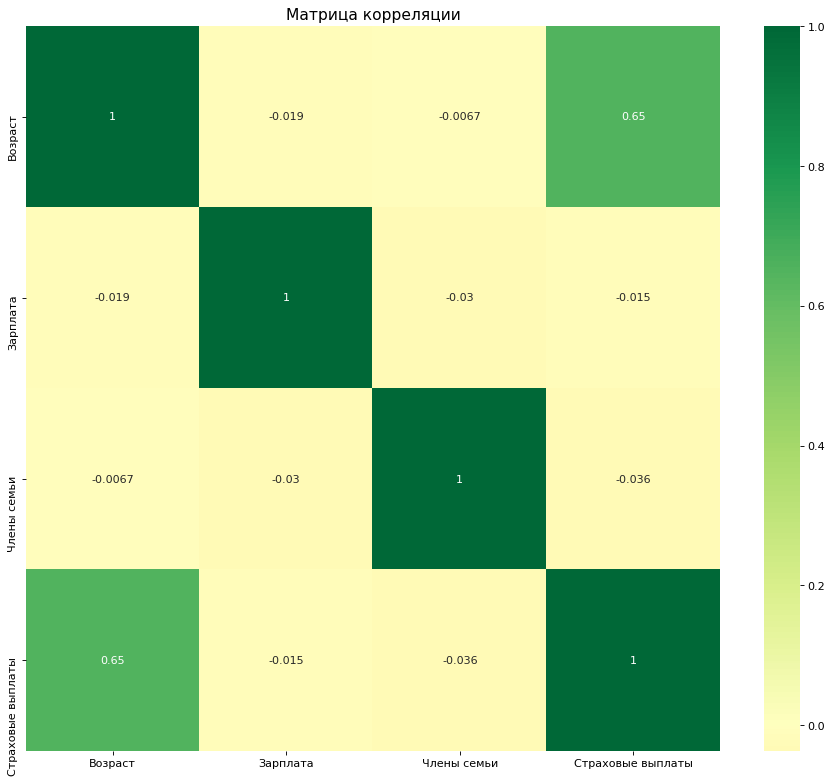

In [7]:
#выведем дополнительно матрицу корреляций
plt.figure(figsize=(14,12), dpi= 80)
sns.heatmap(t.corr(), xticklabels=t.corr().columns, 
            yticklabels=t.corr().columns, cmap='RdYlGn', 
            center=0, annot=True)

plt.title('Матрица корреляции', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Похоже, что столбцы 'Возраст' и 'Страховые выплаты' мультиколлинеарны. Признак 'Страховые выплаты' - целевой, значит, признак 'Возраст' будет линейно влиять на предсказания модели. В нашей задаче используется модель линейной регрессии, поэтому важно отследить мультиколлинеарность признаков между собой, поскольку она вносит неопределенность в модель. Это грозит тем, что для разных выборок результаты оценок могут сильно отличаться, несмотря на однородность.

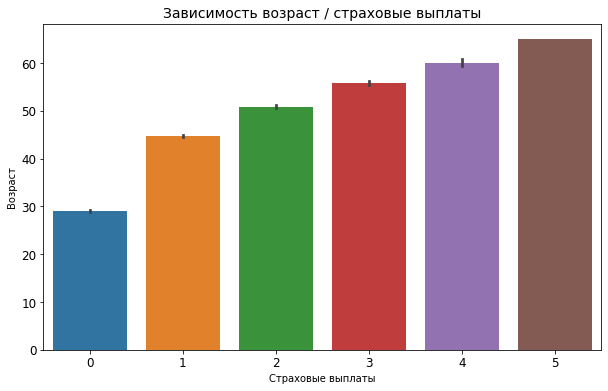

In [8]:
#посмотрим подробнее на зависимость признаков на диаграмме
plt.figure(figsize=(10,6))
sns.barplot(x='Страховые выплаты', y='Возраст', data=t);

plt.title('Зависимость возраст / страховые выплаты', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Заивисмость очевидна - чем старше клиент, тем больше страховых выплат было получено за период пять лет. 

## Умножение матриц

Ответим на вопрос: изменится ли качество линейной регрессии, если признаки умножить на обратимую матрицу?

Для этого введем обозначения и запишем основные понятия линеной регрессии.

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

Предположим, что качество линейной регрессии не изменится. Исходя из этого предположения выполним несколько преобразований и посмотрим, как связаны параметры линейной регрессии в исходной задаче и в преобразованной.

Для выполнения преобразований необходимо использовать следующие свойства операций над матрицами:

$$
(AB)^T = B^T A^T,
$$

$$
(AB)^{-1}) = B^{-1} A^{-1}.
$$

При этом необходимо учитывать, что только квадратная матрица может иметь обратную. 

Запишем формулу для вычисления предсказаний для преобразованного варианта задачи с умножением матрицы признаков на обратимую матрицу P:

$$
a_p = XP w_p.
$$

Также преобразуем формулу обучения:

$$
w_p = ((XP)^T XP)^{-1} (XP)^T y.
$$

Далее выполним подстановку w_p в формулу для вычисления предсказаний:

$$
a_p = XP ((XP)^T XP)^{-1} (XP)^T y.
$$

Раскроем в первую очередь операции транспонирования и переставим скобки внутри выражения для удобства:

$$
a_p = XP (P^T (X^T X) P)^{-1} P^T X^T y.
$$

Таким образом, получаем три квадратные матрицы, для которых можно найти обратные:

$$
a_p = X P P^{-1} (X^T X)^{-1} (P^T)^{-1} P^T X^T y,
$$

Выражения $(P^T)^{-1} P^T$ и $P^{-1} P$ дают в результате единичную матрицу:

$$
a_p = X (X^T X)^{-1} X^T y,
$$

Можно заметить, что выражение $(X^T X)^{-1} X^T y$ равно вектору весов для исходной задачи $w$. Тогда можно заменить это выражение и получим формулировку для исходной задачи:
$$
a_p = X w,
$$
тогда:

$$
a_p = a,
$$

Результат сокращений получится идентичный для исходной и преобразованной задачи, а значит, умножение матрицы признаков на обратимую не влияет на метрики качества линейной регрессии. 

Далее найдем связь параметров линейной регрессии в исходной и преобразованной задаче. Для этого запишем оба выражения:
$$
w = (X^T X)^{-1} X^T y;
$$

$$
w_p = ((XP)^T XP)^{-1} (XP)^T y.
$$

После транспонирования внутреннего выражения, по аналогии с тем, что было выполнено выше, получаем для $w_p$:

$$
w_p = (P^T X^T XP)^{-1} P^T X^T y = P^{-1} (X^T X)^{-1} (P^T)^{-1} P^T X^T y =  P^{-1} (X^T X)^{-1} X^T y;
$$

выражение $(X^T X)^{-1} X^T y$ можно наменить на $w$, тогда получим искомое соотношение парметров $w$ и $w_p$:

$$
w_p = w P^{-1}.
$$

Таким образом, параметры $w$ и $w_p$ связаны обратимой матрицей $P^{-1}$.


**Ответ:** При умножении матрицы признаков на обратимую матрицу метрики линейной регрессии не изменяются. Параметры линейной регрессии в исходной задаче и в преобразованной связаны матрицей $P$, на которую умнжнаяются признаки: $w_p = w P^{-1}$

**Обоснование:** Преобразования, представленные выше, показывают, как матрица признаков сокращается до единичной при выполнении условия минимума функции метрики MSE. Таким образом, если матрицы признаков для обучения и теста умножить на одну и ту же обратимую матрицу - метрика качества линейной регрессии не изменится.

## Алгоритм преобразования

Для шифрования наших данных реализуем аналитический метод шифрования, основанный на линейных преобразованиях матриц - метод Хилла. В оригинальном методе Хилла матрица ключа умножается на вектор открытого текста. Таким образом, размер ключа составляет $n$ x $n$, где n-количество строк открытого текста. В нашем случае размеры выборок разные и могут изменяться в процессе доработок. В связи с этим будет использован обратный порядок умножения, то есть, матрица открытого текста будет умножаться на матрицу ключа, чтобы размер ключа соотвестовал количеству столбцов в матрице текста (этот параметр остается без изменений как для тренировочной, так и для тестовой выборки).

**Алгоритм**

Обозначения:

$X$ — матрица признаков (нулевой столбец состоит из единиц);

$P$ — матрица - ключ;

$C$ — зашифрованный текст.

1. Зададим квадратную матрицу ключа $P$ размером $n$ x $n$. Это может быть случайный, но воспроизводимый для дешифровки, набор цифр. Кроме того, матрица ключа должна иметь обратную.
2. Произведем умножение матриц, в результате чего получим матрицу зашифрованного текста:

$$
C = XP.
$$

3. Чтобы расшифровать данные, воспользуемся выражением для поиска обратной матрицы:
$$
P^{-1} = \frac{1}{P}
$$

Таким образом, исходный текст можно получить путем произведения обратной матрицы ключа и матрицы зашифрованного текста:
$$
X = C P^{-1}
$$




**Обоснование**

Этот метод основан на преобразовании вектора данных путем умножения на матрицу ключа. Как было доказано выше, такое преобразование зашифрует данные и позволит сохранить метрики качества модели без изменений. Для выполнения условия сохранения метрик модели линейной регрессии, матрица ключа должна быть константной для всех выборок.

## Проверка алгоритма

In [9]:
#выделим признаки
X = df_raw.drop(['Страховые выплаты'], axis=1)
y = df_raw['Страховые выплаты']

#разделим выборки на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

#убедимся в правильности разделения
print('Train:')
display(X_train.shape)
display(y_train.shape)
print('Test:')
display(X_test.shape)
display(y_test.shape)

Train:


(3750, 4)

(3750,)

Test:


(1250, 4)

(1250,)

In [10]:
#Исследуем модель по методу линейной регрессии и гиперпараметрами по умолчанию для исходной задачи

model = LinearRegression() #обучим модель

model.fit(X_train, y_train) # обучим модель на тренировочной выборке
predictions = model.predict(X_test) # получим предсказания модели
result = r2_score(y_test, predictions)  # посчитаем качество модели для предсказания

In [11]:
#далее получим метрики для преобразованной задачи

#создадим матрицу-ключ, обеспечив при этом гарантированную обратимость
def key_encryption(data):
    P = np.random.normal(size=(data.shape[1], data.shape[1]))
    if np.linalg.det(P) != 0:
        return P
    return print('det = 0')

P = key_encryption(X)

#создадим преобразованные выборки, умножих их на ключ
X_train_trans = X_train.dot(P)
X_test_trans = X_test.dot(P)

#далее получим предсказание
model.fit(X_train_trans, y_train) # обучим модель на тренировочной выборке
predictions_trans = model.predict(X_test_trans) # получим предсказания модели
result_trans = r2_score(y_test, predictions_trans)  # посчитаем качество модели для предсказания

print("R2 для исходной задачи:", round(result, 4))
print("MSE для исходной задачи:", round(mean_squared_error(y_test, predictions), 4))
print()
print("R2 после преобразования:", round(result_trans, 4))
print("MSE после преобразования:", round(mean_squared_error(y_test, predictions_trans), 4))

R2 для исходной задачи: 0.4255
MSE для исходной задачи: 0.1386

R2 после преобразования: 0.4255
MSE после преобразования: 0.1386


Результаты работы модели показали, что метрика качества не изменилась после преобразования признаков.

In [12]:
#выполним расшифровку данных

#получим обратную матрицу ключа
P_inv = np.linalg.inv(P)

#выполним преобразование
X_train_dec = X_train_trans.dot(P_inv)
X_test_dec = X_test_trans.dot(P_inv)

X_train_dec.columns = X_train.columns
X_test_dec.columns = X_test.columns

#сравним дешифрованные данные с исходными
display((X_train_dec - X_train).mean().round(1))
display((X_test_dec - X_test).mean().round(1))

Пол            0.0
Возраст        0.0
Зарплата      -0.0
Члены семьи   -0.0
dtype: float64

Пол            0.0
Возраст        0.0
Зарплата      -0.0
Члены семьи   -0.0
dtype: float64

Такой алгоритм поволяет корректно шифровать и дешифровать данные без риска ухудшения метрик качества модели линейной регрессии.

## Выводы

Задача проекта выполнена - метод преобразования данных разработан и обоснована корректность его работы. 

Достигнута цель проекта - качество модели машинного обучения не изменилось после преобразования исходных данных.

В ходе выполнения проекта выполнены следующие этапы и получены результаты:

1. Данные загружены, предобработка не потребовалась.
2. При умножении признаков на обратимую матрицу качество линейной регрессии не изменится. Вывод обоснован аналитически. Для параметров линейной регрессии в исходной задаче и в преобразованной выполняется соотношение: $w_p = w P^{-1}$.
3. Предложен алгоритм преобразования данных для решения задачи.
4. Алгоритм реализован и проверен на модели - метрики качества до и после преобразования признаков не изменяются.